In [1]:
import numpy as np
import pandas as pd
import math
from math import sin, cos, radians, pi

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
def point_pos(x0, y0, d, theta):
    theta_rad = radians(theta)
    return x0 + d*cos(theta_rad), y0 + d*sin(theta_rad)

def given_two_point_find_rectangle(x0,y0,x1,y1,roller_length=5):
    d=roller_length/2
    theta=math.degrees(math.atan2((y1-y0),(x1-x0))) 
    print("theta made with positive x axis=",theta)
    (xa,ya)=point_pos(x0,y0,d,theta-90)
    (xb,yb)=point_pos(x0,y0,d,theta+90)
    (xc,yc)=point_pos(x1,y1,d,theta+90)
    (xd,yd)=point_pos(x1,y1,d,theta-90)
    return (xa,ya),(xb,yb),(xc,yc),(xd,yd)

def get_pass_values_and_update_f_value(rectangle_points,f_values):
    rectangle=Polygon(rectangle_points)
    pass_values=[]
    for ix in range(len(list_x)):
        for iy in range(len(list_y)):
            if rectangle.contains(Point(list_x[ix],list_y[iy])):
                pass_values.append(f_values[iy,ix])
                f_values[iy,ix]+=1
    return np.average(pass_values)+1

In [3]:
def create_average_pass_count(data,min_x=None,max_x=None,min_y=None,max_y=None):
    data["prev_lat"]=data["latitude"].shift(1)
    data["prev_long"]=data["longitude"].shift(1)
    data["prev_pass"]=data["passID"].shift(1)

    #Constants
    rolller_length=0.0000115*0.3048*6

    #Hyper-parameters
    grid_size_x=0.000005*0.3048
    grid_size_y=0.000006*0.3048

    #Parameters
    if min_x==None:
        min_x=min_lat=data["latitude"].min()
    else:
        min_lat=min_x
    if max_x==None:
        max_x=max_lat=data["latitude"].max()
    else:
        max_lat=max_x
    if min_y==None:
        min_y=min_long=data["longitude"].min()
    else:
        min_long=min_y
    if max_y==None:
        max_y=max_long=data["longitude"].max()
    else:
        max_long=max_y
        
    print("min_x,max_x,min_y,max_y",min_x,max_x,min_y,max_y)
    
    print(max_x-min_x,max_y-min_y, "diff_x,diff_y")

    #create_matrix_grid
    print(min_x+(grid_size_x/2)-(rolller_length/2),max_x+(rolller_length/2),grid_size_x, "roller length", rolller_length)
    list_x=np.arange(min_x+(grid_size_x/2)-(rolller_length/2),max_x+(rolller_length/2),grid_size_x)
    list_y=np.arange(min_y+(grid_size_y/2)-(rolller_length/2),max_y+(rolller_length/2),grid_size_y)
    
    print(list_x)

    data=data[data["passID"]==data["prev_pass"]]
    
    xv,yv=np.meshgrid(list_x,list_y)
    f_values=np.zeros(xv.shape)
    
    def point_pos(x0, y0, d, theta):
    theta_rad = radians(theta)
    return x0 + d*cos(theta_rad), y0 + d*sin(theta_rad)
    
    def given_two_point_find_rectangle(x0,y0,x1,y1):
        d=rolller_length/2
        theta=math.degrees(math.atan2((y1-y0),(x1-x0))) 
#         print("theta made with positive x axis=",theta)
        (xa,ya)=point_pos(x0,y0,d,theta-90)
        (xb,yb)=point_pos(x0,y0,d,theta+90)
        (xc,yc)=point_pos(x1,y1,d,theta+90)
        (xd,yd)=point_pos(x1,y1,d,theta-90)
        return (xa,ya),(xb,yb),(xc,yc),(xd,yd)
    
    def get_pass_values_and_update_f_value(rectangle_points):
        rectangle=Polygon(rectangle_points)
        pass_values=[]
        pass_location=[]
#         print(f_values)
        for ix in range(len(list_x)):
            for iy in range(len(list_y)):
                if rectangle.contains(Point(list_x[ix],list_y[iy])):
                    pass_location.append([ix,iy])
                    pass_values.append(f_values[iy,ix])
                    f_values[iy,ix]+=1
#         print("new line",pass_location,"\n",pass_values)
        return np.average(pass_values)+1
    
#     min_x,max_x,min_y,max_y,len(list_x),len(list_y),f.shape
    data["rect_points"]=data[["prev_lat","prev_long","latitude","longitude"]].apply(lambda x:
                                                                                         given_two_point_find_rectangle(x.prev_lat,x.prev_long,x.latitude,x.longitude),
                                                                                         axis=1
                                                                                        )
#     data["average_pass_count"]=data["rect_points"].apply(lambda x: get_pass_values_and_update_f_value(x))
    
    op_data_list=[]
    every_fifth_pass=[]
    for i, row in enumerate(data.itertuples(), 1):
        op_data_list.append(get_pass_values_and_update_f_value(row.rect_points))
        every_fifth_pass.append(f_values.copy())
    data["average_pass_count"]=op_data_list

    return data,xv,yv,f_values,every_fifth_pass





In [4]:
data=pd.read_csv("Example_full_data.csv")
data=data[[ 'total_power', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'cluster', 'latitude', 'longitude',
       'heading', 'passID']]
# data

data["previous_lat"]=data["latitude"].shift(1)
data["previous_long"]=data["longitude"].shift(1)
data["previous_pass"]=data["passID"].shift(1)
data["next_pass"]=data["passID"].shift(-1)
data

,total_power,p0,p1,p2,p3,p4,p5,p6,cluster,latitude,longitude,heading,passID,previous_lat,previous_long,previous_pass,next_pass
0,100.000000,-2.000000,2.000000,2.000000,0.935329,2.000000,2.000000,2.000000,4,35.670014,-96.662317,89.042705,1,NaN,NaN,NaN,1.0
1,82.183425,-2.000000,-0.085897,-0.100313,0.562901,1.384732,0.605973,0.031654,3,35.670016,-96.662317,89.042705,1,35.670014,-96.662317,1.0,1.0
2,83.212034,-2.000000,0.909739,-0.090134,0.542970,0.487589,0.860677,-0.756443,0,35.670018,-96.662317,89.042705,1,35.670016,-96.662317,1.0,1.0
3,58.360112,-0.510243,-0.707589,-0.276745,-0.355957,-0.028058,0.654395,-0.147354,2,35.670021,-96.662317,89.042705,1,35.670018,-96.662317,1.0,1.0
4,62.575446,0.922105,-0.875624,-0.435802,0.125723,-0.576983,0.532818,-0.837134,2,35.670023,-96.662317,89.042705,1,35.670021,-96.662317,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,18.406951,0.619154,2.000000,-0.067383,-0.711903,-0.299709,-0.395371,-0.997861,2,35.670775,-96.662319,88.967755,4,35.670773,-96.662319,4.0,4.0
1448,67.584552,0.658804,0.218019,-0.212631,-0.182176,1.719183,1.880953,-0.183528,4,35.670778,-96.662319,88.967755,4,35.670775,-96.662319,4.0,4.0
1449,82.175854,0.966712,0.201359,0.004933,2.000000,0.814174,-0.509651,0.454917,3,35.670780,-96.662319,88.967755,4,35.670778,-96.662319,4.0,4.0
1450,100.000000,1.250349,-0.648439,1.299200,2.000000,-0.037076,-0.079023,1.638104,3,35.670782,-96.662319,88.967755,4,35.670780,-96.662319,4.0,4.0


In [5]:
data_op,xv,yv,f_values,every_fifth_pass=create_average_pass_count(data)

min_x,max_x,min_y,max_y 35.67 35.6708 -96.662342 -96.662304
0.0007999999999981355 3.799999998932435e-05 diff_x,diff_y
35.6699902464 35.6708105156 1.5240000000000001e-06 roller length 2.1031200000000003e-05
[35.66999025 35.66999177 35.66999329 35.66999482 35.66999634 35.66999787
 35.66999939 35.67000091 35.67000244 35.67000396 35.67000549 35.67000701
 35.67000853 35.67001006 35.67001158 35.67001311 35.67001463 35.67001615
 35.67001768 35.6700192  35.67002073 35.67002225 35.67002377 35.6700253
 35.67002682 35.67002835 35.67002987 35.67003139 35.67003292 35.67003444
 35.67003597 35.67003749 35.67003901 35.67004054 35.67004206 35.67004359
 35.67004511 35.67004663 35.67004816 35.67004968 35.67005121 35.67005273
 35.67005425 35.67005578 35.6700573  35.67005883 35.67006035 35.67006187
 35.6700634  35.67006492 35.67006645 35.67006797 35.67006949 35.67007102
 35.67007254 35.67007407 35.67007559 35.67007711 35.67007864 35.67008016
 35.67008169 35.67008321 35.67008473 35.67008626 35.67008778 35.6

/home/spoudel/anaconda3/envs/rica/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/spoudel/anaconda3/envs/rica/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


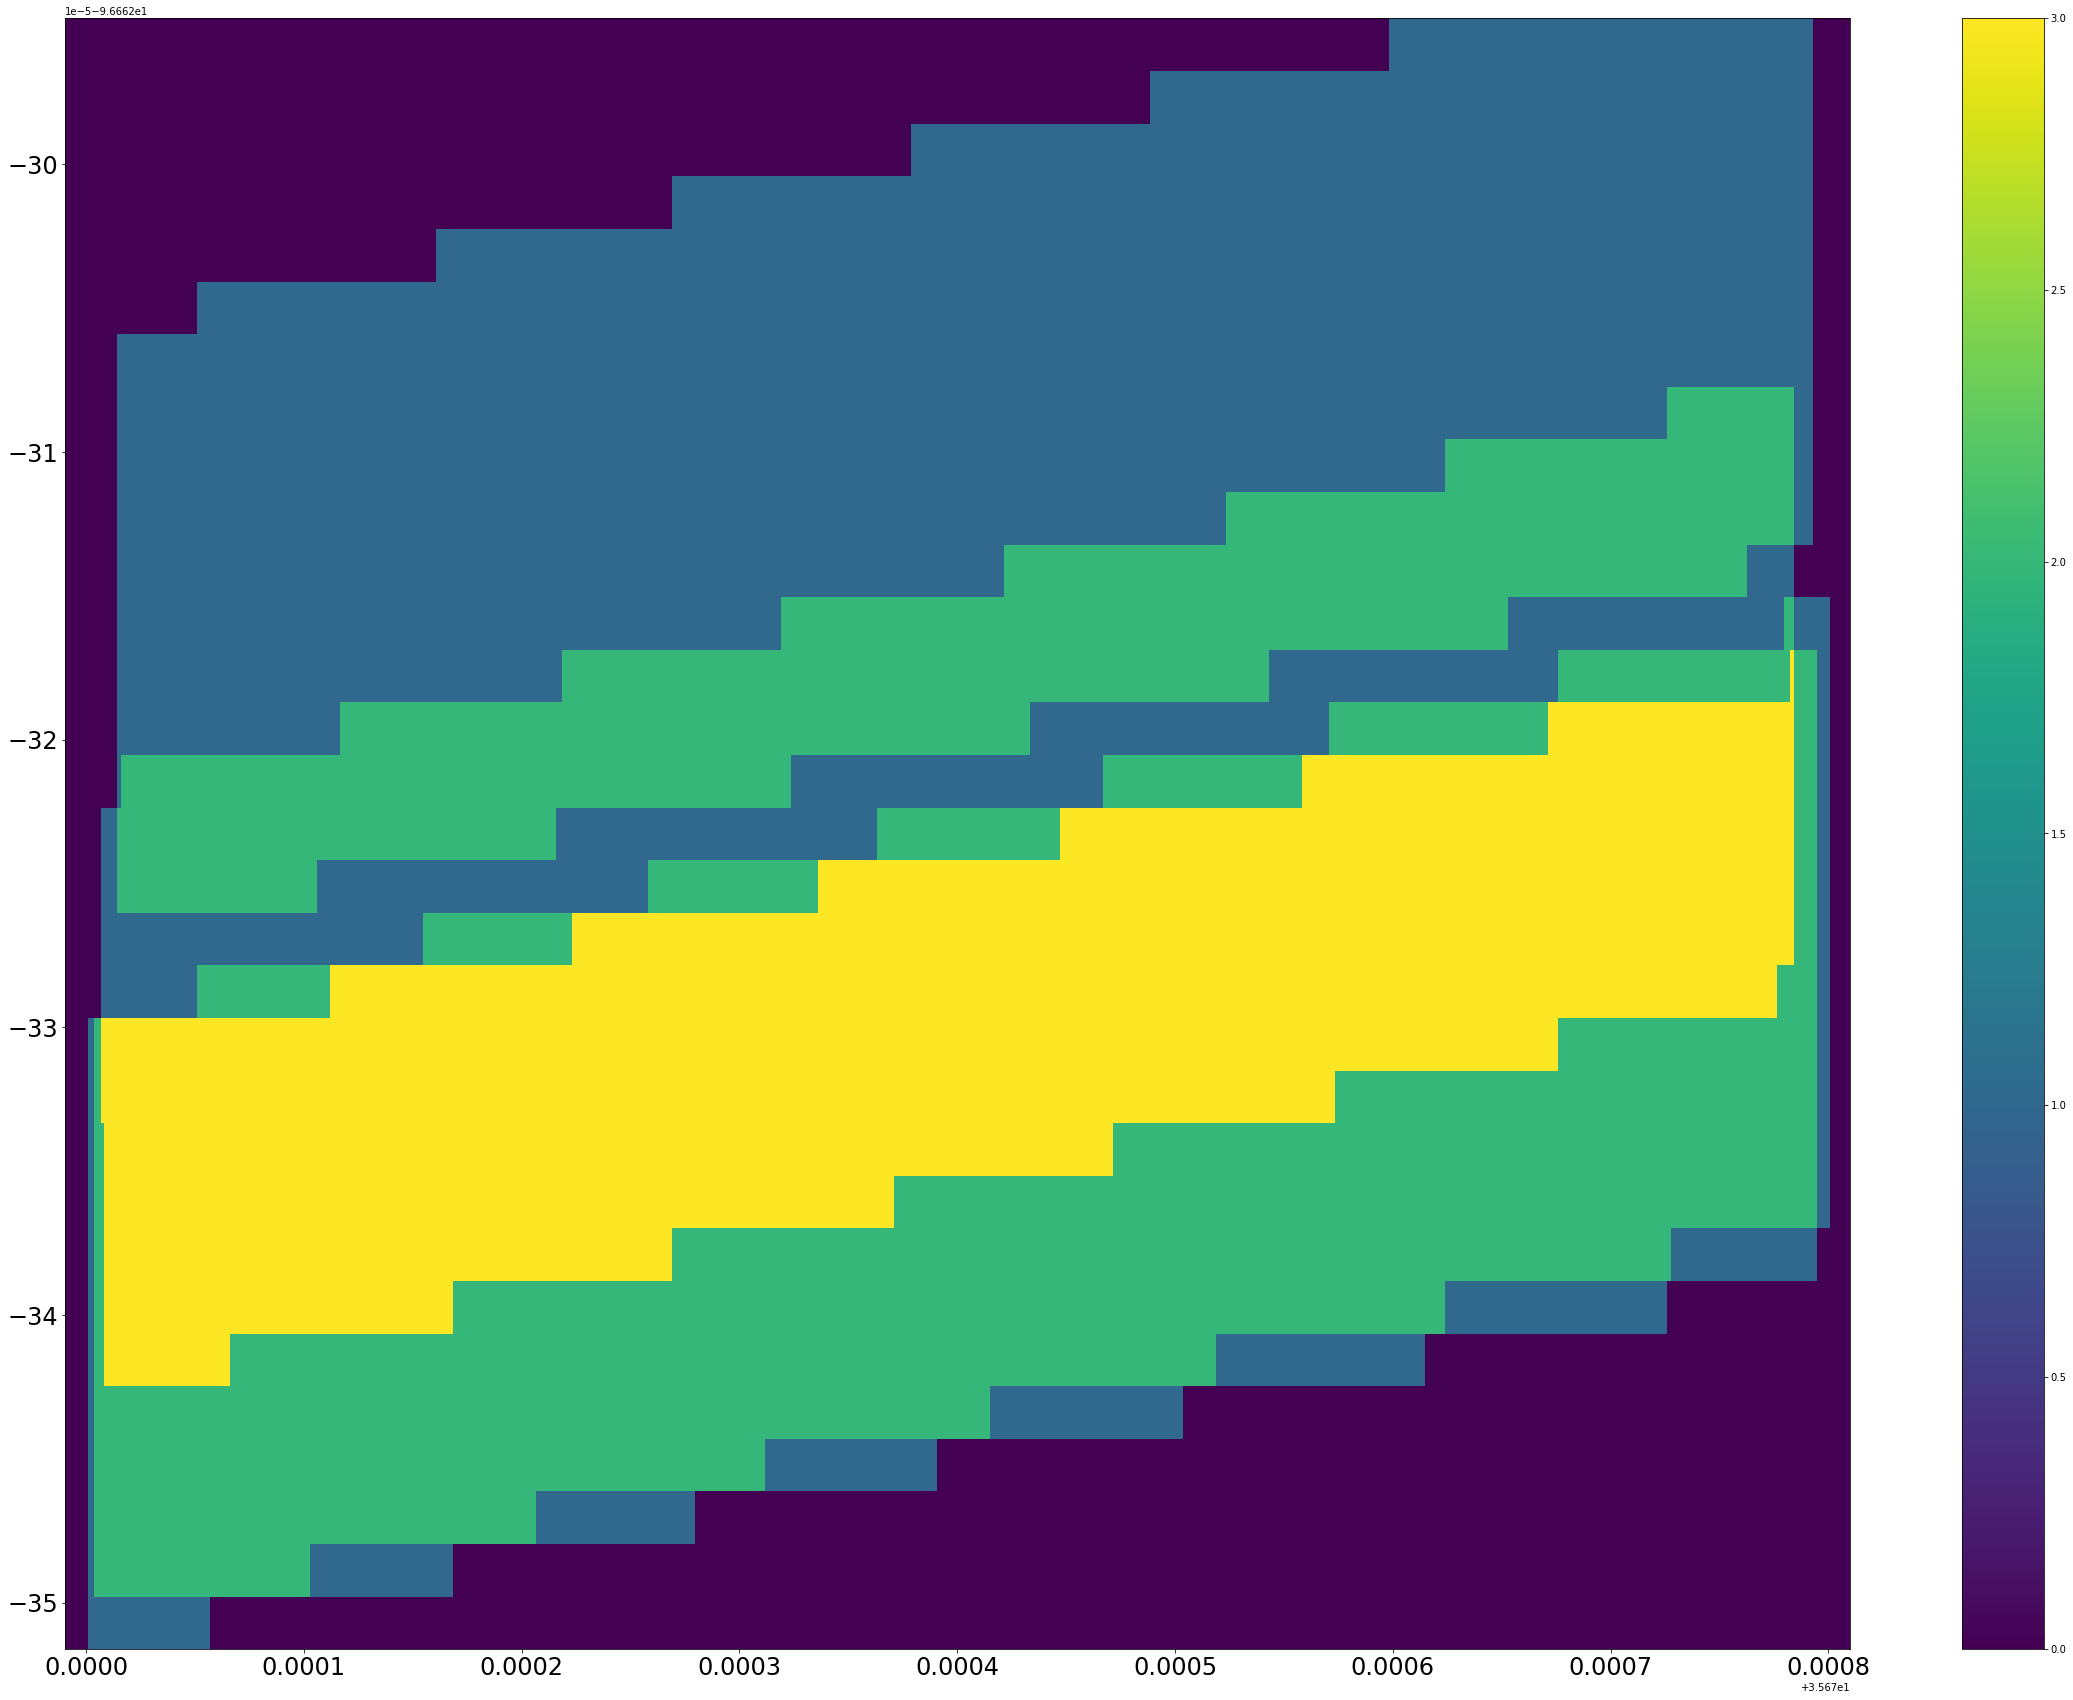

In [6]:
plt.figure(figsize=(40,30))
plt.pcolormesh(xv,yv,f_values)
plt.colorbar()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [9]:
data_op["average_pass_count"].max()

2.666666666666667